# Meta-Model Structure Selection (MetaMSS) algorithm for building Polynomial NARX models

Example created by Wilson Rocha Lacerda Junior

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import MetaMSS, FROLS
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)

<Axes: >

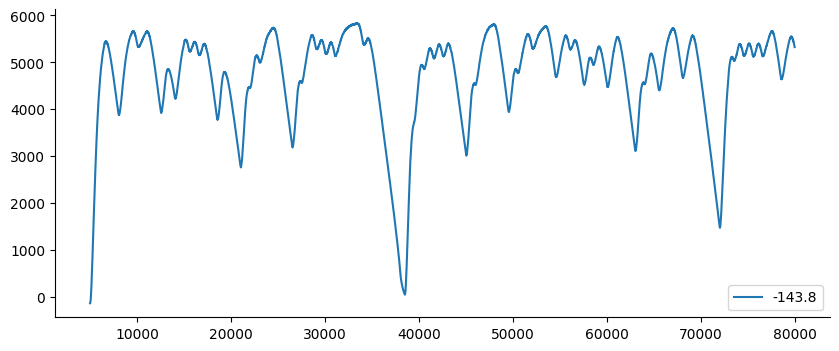

In [2]:
df1 = pd.read_csv("./datasets/x_cc.csv")
df2 = pd.read_csv("./datasets/y_cc.csv")

df2[5000:80000].plot(figsize=(10, 4))

In [3]:
df1.iloc[::500].values.shape

(1000, 1)

We will decimate the data using d=500 in this example.
Besides, we separate the MetaMSS data to use the same amount of samples in the prediction validation. Because MetaMSS need a train and test data to optimize the parameters of the model, in this case, we'll use 400 samples to train instead of 500 samples used for the other models. 

In [4]:
x_train_meta, x_test_meta, x_validation_meta, _ = np.split(
    df1.iloc[::500].values, [400, 500, 1000]
)
y_train_meta, y_test_meta, y_validation_meta, _ = np.split(
    df2.iloc[::500].values, [400, 500, 1000]
)

x_train, x_test = np.split(df1.iloc[::500].values, 2)
y_train, y_test = np.split(df2.iloc[::500].values, 2)

In [5]:
basis_function = Polynomial(degree=2)

model = MetaMSS(
    norm=-2,
    xlag=3,
    ylag=3,
    estimator="recursive_least_squares",
    k_agents_percent=10,
    estimate_parameter=True,
    maxiter=30,
    n_agents=10,
    loss_func="metamss_loss",
    basis_function=basis_function,
    random_state=42,
)
model.fit(
    X=x_train_meta, y=y_train_meta, X_test=x_validation_meta, y_test=y_validation_meta
)

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use MetaMSS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: You will not need to pass X_test and y_test in v0.4.0. 
 You'll have to use MetaMSS(test_size=0.25) instead. 
 This change will make easier to use the MetaMSS model and will follow the same structure of the other methods.
  warnings.warn(message, FutureWarning)
c:\Users\wilso\miniconda3\envs\v0.3.3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.

0.0333419637006627
        Regressors   Parameters             ERR
0                1  -3.5513E+02  0.00000000E+00
1           y(k-1)   1.4835E+00  0.00000000E+00
2           y(k-2)  -5.3744E-01  0.00000000E+00
3          x1(k-2)   2.6056E+02  0.00000000E+00
4          x1(k-3)  -4.6979E+00  0.00000000E+00
5     y(k-3)y(k-1)   1.3104E-05  0.00000000E+00
6    x1(k-1)y(k-1)  -1.6041E-01  0.00000000E+00
7    x1(k-2)y(k-1)  -6.8079E-02  0.00000000E+00
8    x1(k-3)y(k-1)   1.3481E-02  0.00000000E+00
9     y(k-3)y(k-2)  -1.9122E-05  0.00000000E+00
10   x1(k-1)y(k-2)   9.1429E-02  0.00000000E+00
11   x1(k-2)y(k-2)   3.5621E-02  0.00000000E+00
12   x1(k-3)y(k-2)   5.7288E-03  0.00000000E+00
13        y(k-3)^2   1.3004E-05  0.00000000E+00
14   x1(k-1)y(k-3)  -1.9402E-02  0.00000000E+00
15   x1(k-2)y(k-3)  -8.7897E-03  0.00000000E+00
16       x1(k-1)^2   1.1771E+02  0.00000000E+00
17  x1(k-2)x1(k-1)  -2.4822E+00  0.00000000E+00
18  x1(k-3)x1(k-1)   2.8744E+00  0.00000000E+00
19       x1(k-3)^2  -

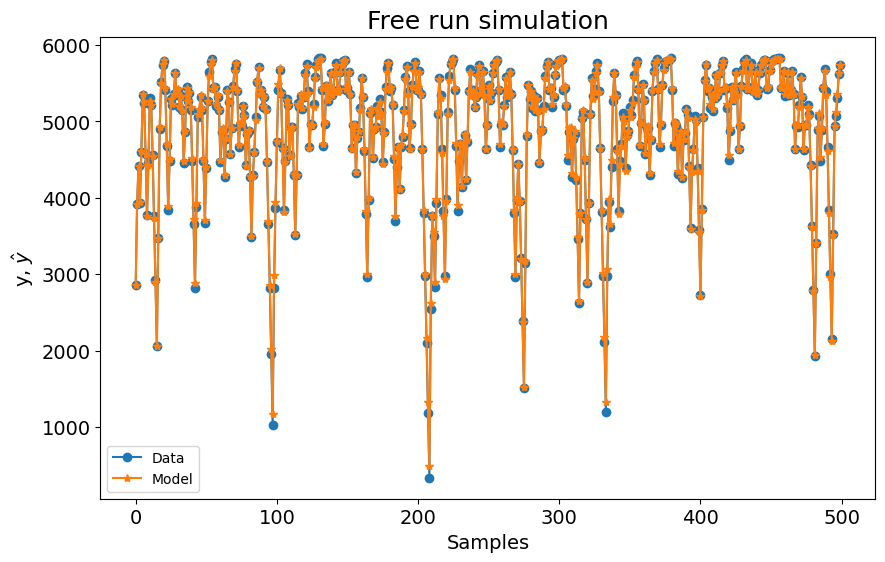

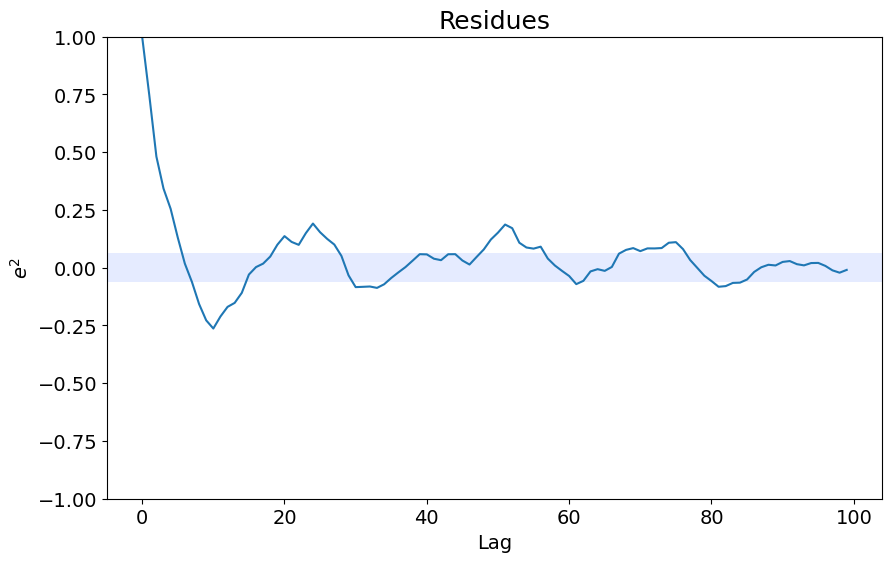

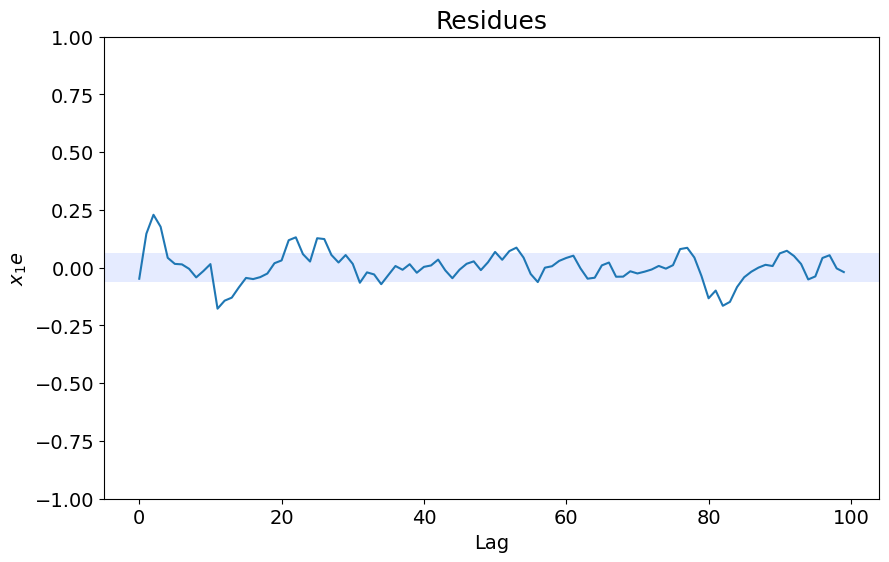

In [6]:
yhat = model.predict(X=x_validation_meta, y=y_validation_meta, steps_ahead=None)
rrse = root_relative_squared_error(y_validation_meta, yhat)
print(rrse)

r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)

plot_results(y=y_validation_meta, yhat=yhat, n=1000)
ee = compute_residues_autocorrelation(y_validation_meta, yhat)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")
x1e = compute_cross_correlation(y_validation_meta, yhat, x_validation_meta)
plot_residues_correlation(data=x1e, title="Residues", ylabel="$x_1e$")

0.003898009726092222

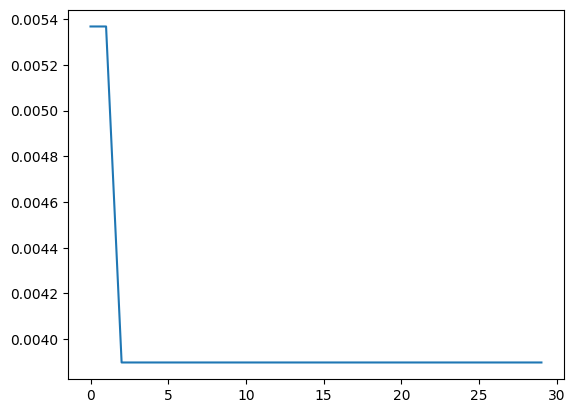

In [7]:
# Plotting the evolution of the agents
plt.plot(model.best_by_iter)
model.best_by_iter[-1]

In [8]:
# You have access to all tested models
# model.tested_models

In [9]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor,
)
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostRegressor
from sklearn.linear_model import BayesianRidge, ARDRegression
from sysidentpy.general_estimators import NARX

xlag = ylag = 10

estimators = [
    (
        "NARX_KNeighborsRegressor",
        NARX(
            base_estimator=KNeighborsRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_DecisionTreeRegressor",
        NARX(
            base_estimator=DecisionTreeRegressor(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_RandomForestRegressor",
        NARX(
            base_estimator=RandomForestRegressor(n_estimators=200),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "NARX_Catboost",
        NARX(
            base_estimator=CatBoostRegressor(
                iterations=800, learning_rate=0.1, depth=8
            ),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
            fit_params={"verbose": False},
        ),
    ),
    (
        "NARX_ARD",
        NARX(
            base_estimator=ARDRegression(),
            xlag=xlag,
            ylag=ylag,
            basis_function=basis_function,
        ),
    ),
    (
        "FROLS-Polynomial_NARX",
        FROLS(
            order_selection=True,
            n_info_values=50,
            extended_least_squares=False,
            ylag=ylag,
            xlag=xlag,
            info_criteria="bic",
            estimator="recursive_least_squares",
            basis_function=basis_function,
        ),
    ),
    (
        "MetaMSS",
        MetaMSS(
            norm=-2,
            xlag=xlag,
            ylag=ylag,
            estimator="recursive_least_squares",
            k_agents_percent=10,
            estimate_parameter=True,
            maxiter=20,
            n_agents=15,
            loss_func="metamss_loss",
            basis_function=basis_function,
            random_state=42,
        ),
    ),
]


resultados = {}
for nome_do_modelo, modelo in estimators:
    resultados["%s" % (nome_do_modelo)] = []
    if nome_do_modelo == "MetaMSS":
        modelo.fit(X=x_train, y=y_train, X_test=x_test, y_test=y_test)
        yhat = modelo.predict(X=x_validation_meta, y=y_validation_meta)
    else:
        modelo.fit(X=x_train, y=y_train)
        yhat = modelo.predict(X=x_test, y=y_test)
    if nome_do_modelo == "MetaMSS":
        result = root_relative_squared_error(
            y_validation_meta[modelo.max_lag :], yhat[modelo.max_lag :]
        )
    if nome_do_modelo == "FROLS-Polynomial_NARX":
        result = root_relative_squared_error(
            y_test[modelo.max_lag :], yhat[modelo.max_lag :]
        )
    else:
        result = root_relative_squared_error(y_test, yhat)
    resultados["%s" % (nome_do_modelo)].append(result)
    print(nome_do_modelo, "%.3f" % np.mean(result))

C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use MetaMSS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


NARX_KNeighborsRegressor 1.165
NARX_DecisionTreeRegressor 0.257
NARX_RandomForestRegressor 0.191
NARX_Catboost 0.157
NARX_ARD 0.070
FROLS-Polynomial_NARX 0.046


C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: You will not need to pass X_test and y_test in v0.4.0. 
 You'll have to use MetaMSS(test_size=0.25) instead. 
 This change will make easier to use the MetaMSS model and will follow the same structure of the other methods.
  warnings.warn(message, FutureWarning)
c:\Users\wilso\miniconda3\envs\v0.3.3\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\narmax_base.py:719: RuntimeWarning: overflow encountered in power
  regressor_value[j] = np.prod(np.power(raw_regressor, model_exponent))
C:\Users\wilso\Desktop\projects\GitHub\sysidentpy\sysidentpy\model_structure_selection\meta_model_structure_selection.py:465: RuntimeWarning: overflow encountered in square
  sum_of_squared_residues = np.sum(residues**2)
C:\Users\wilso\Desktop\pr

MetaMSS 0.025


In [10]:
for aux_results, results in sorted(
    resultados.items(), key=lambda x: np.mean(x[1]), reverse=False
):
    print(aux_results, np.mean(results))

MetaMSS 0.025270255361927386
FROLS-Polynomial_NARX 0.04595606904272196
NARX_ARD 0.0704838592994891
NARX_Catboost 0.15735233093778006
NARX_RandomForestRegressor 0.19086216946473913
NARX_DecisionTreeRegressor 0.2570981305420654
NARX_KNeighborsRegressor 1.1649427863250668
